In [14]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [16]:
# data_pd = pd.read_csv("E:\prog\\trading\parkinsons.data")
# label_pd = data_pd["status"]
# data_pd.drop(["status","name"],axis = 1,inplace = True)

# print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

In [17]:
# data_pd = pd.read_csv("E:\prog\\trading\creditcard.csv")
# data_pd=pd.concat([data_pd[data_pd["Class"]==1][:480],data_pd[data_pd["Class"]==0][:480]],axis=0)
# label_pd = data_pd["Class"]
# data_pd.drop(["Class","Time"],axis = 1,inplace = True)

# print("creditcard dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

In [18]:
data_pd = pd.read_csv("E:\prog\\trading\mushrooms.csv")
label_pd = data_pd["class"]
label_pd=pd.get_dummies(label_pd,drop_first=True)
data_pd.drop(["class"],axis = 1,inplace = True)
data_pd=pd.get_dummies(data_pd)

print("mushrooms dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

mushrooms dataset:
 8124 Records
 117 Features


In [19]:
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [20]:
X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)

In [21]:
def initilization_of_population(size,n_feat):
    population = []
    for j in range(0,9):
        for _ in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)     
            chromosome[:int((j/10)*n_feat)]=False             
            np.random.shuffle(chromosome)
            population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel = DecisionTreeClassifier(random_state=0)
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    # print(len(scores))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                 
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

def balanced_fitness(population,alpha=0.5):
    accuracy = []
    scores=[]
    for chromosome in population:
        if(sum(chromosome)==0):
            x=random.choice(range(len(chromosome)))
            chromosome[x]=True
        logmodel = DecisionTreeClassifier(random_state=0)
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        accuracy.append(accuracy_score(Y_test,predictions))
    # print(len(scores))

    accuracy, population = np.array(accuracy), np.array(population) 

    for i in range(len(accuracy)):
        P=accuracy[i]
        fitness=(alpha*(P) + (1.0 - alpha)*(1.0 - (sum(population[i]))/len(population[0])))
        scores.append(fitness)


    
    inds = np.argsort(scores)    
    
    return list(np.array(scores)[inds][::-1]),list(accuracy[inds][::-1]), list(population[inds,:][::-1]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def tournamentSelection(population, n_parents, k=2):
    selectedParents = []
    for i in range(n_parents):
        tournament = []
        for j in range(k):
            tournament.append(random.choice(range(len(population))))
        sorted(tournament)
        selectedParent = tournament[0]
        selectedParents.append(population[selectedParent])
    return selectedParents


def crossover(pop_after_sel):
    pop_nextgen=[]
    # pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        parent_1 , parent_2 = pop_after_sel[random.choice(range(len(pop_after_sel)))] , pop_after_sel[random.choice(range(len(pop_after_sel)))]
        
        new_par = np.concatenate((parent_1[:len(parent_1)//2],parent_2[len(parent_1)//2:]))
        pop_nextgen.append(new_par)

        new_par = np.concatenate((parent_2[:len(parent_2)//2],parent_1[len(parent_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def uniform_crossover(pop_after_sel,crossover_prob):
    pop_nextgen=[]
    # pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        parent_1 , parent_2 = pop_after_sel[random.choice(range(len(pop_after_sel)))] , pop_after_sel[random.choice(range(len(pop_after_sel)))]
        
        child1=parent_1
        child2=parent_2

        for i in range(len(parent_1)):
            prob=random.random()
            if(prob<crossover_prob):
                child1[i]=parent_2[i]
                child2[i]=parent_1[i]
        pop_nextgen.append(child1)
        pop_nextgen.append(child2)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for _ in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def bitflip_mutation(pop_after_cross,mutation_rate,n_feat):   
    pop_next_gen = []
    for i in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[i]
        for j in range(n_feat):
            newpr=random.random()
            if(newpr<mutation_rate):
                chromo[j]=not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen



def generations(size,n_feat,n_parents,mutation_rate,n_gen,alpha,crossover_prob):
    best_chromo= []
    best_accuracy=[]
    best_score= []
    # 8*size=8*80=640
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        # scores, pop_after_fit = fitness_score(population_nextgen)
        newfitness,accuracy, pop_after_fit = balanced_fitness(population_nextgen,alpha)
        best_chromo.append(pop_after_fit[0])
        best_score.append(newfitness[0])
        best_accuracy.append(accuracy[0])
        
        print('Best score in generation',i+1,':',accuracy[0],",features used:",sum(pop_after_fit[0]),",fitness score:",newfitness[0])  #2
        # pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_sel= tournamentSelection(pop_after_fit, n_parents,2)
        # pop_after_cross = crossover(pop_after_sel)
        pop_after_cross = uniform_crossover(pop_after_sel,crossover_prob)
        population_nextgen = bitflip_mutation(pop_after_cross,mutation_rate,n_feat)

        for x in range(int(len(pop_after_fit)/10)):
            population_nextgen.append(pop_after_fit[x])
        _,_, pop_after_fit = balanced_fitness(population_nextgen,alpha)
        population_nextgen=pop_after_fit[:n_parents]

    return best_chromo,best_score,best_accuracy

In [22]:
# logmodel = DecisionTreeClassifier(random_state=0,max_depth=3)
size=100
n_parent=size*9
chromo,score,accuracy=generations(size=size,n_feat=data_pd.shape[1],n_parents=n_parent,mutation_rate=0.01,n_gen=150,alpha=0.5,crossover_prob=0.1)

Best score in generation 1 : 1.0 ,features used: 24 ,fitness score: 0.8974358974358975
Best score in generation 2 : 1.0 ,features used: 24 ,fitness score: 0.8974358974358975
Best score in generation 3 : 0.9896602658788775 ,features used: 21 ,fitness score: 0.905086543195849
Best score in generation 4 : 0.9896602658788775 ,features used: 21 ,fitness score: 0.905086543195849
Best score in generation 5 : 0.9896602658788775 ,features used: 21 ,fitness score: 0.905086543195849
Best score in generation 6 : 0.9896602658788775 ,features used: 23 ,fitness score: 0.8965395346488405
Best score in generation 7 : 0.9896602658788775 ,features used: 23 ,fitness score: 0.8965395346488405
Best score in generation 8 : 0.9921221073362876 ,features used: 22 ,fitness score: 0.9020439596510498
Best score in generation 9 : 0.9921221073362876 ,features used: 22 ,fitness score: 0.9020439596510498
Best score in generation 10 : 0.9921221073362876 ,features used: 22 ,fitness score: 0.9020439596510498
Best score i

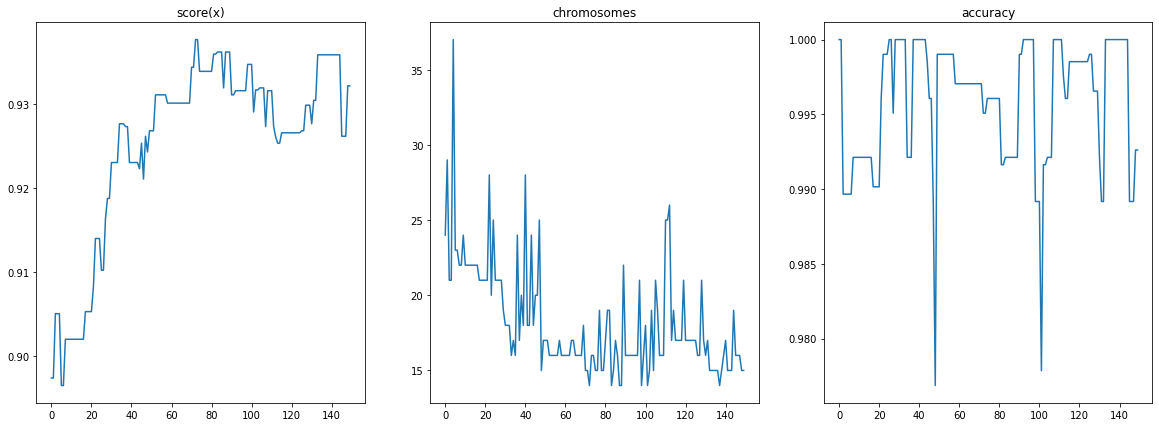

In [23]:
new_ch=[sum(x) for x in chromo]
fig, ax = plt.subplots(ncols=3,figsize=(20,7))

# Plot each data series in a separate subplot
ax[0].plot(score)
ax[1].plot(new_ch)
ax[2].plot(accuracy)

# Set titles for each subplot
ax[0].set_title('score(x)')
ax[1].set_title('chromosomes')
ax[2].set_title('accuracy')

# Display the plot
plt.show()


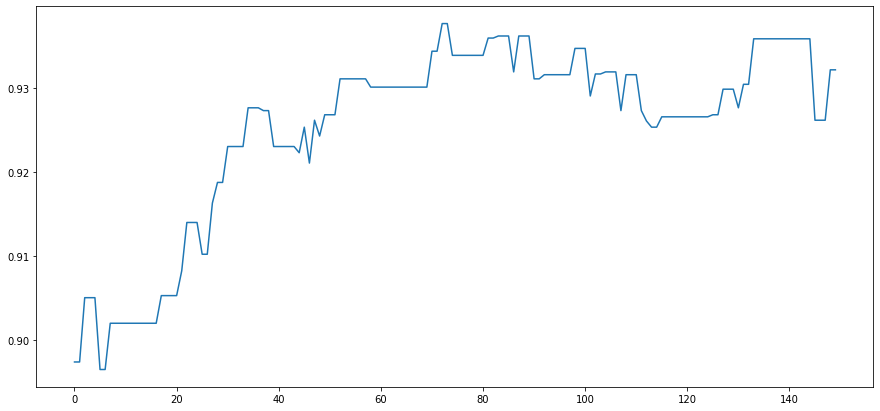

In [40]:
plt.figure(figsize=(15,7))
plt.plot(score)

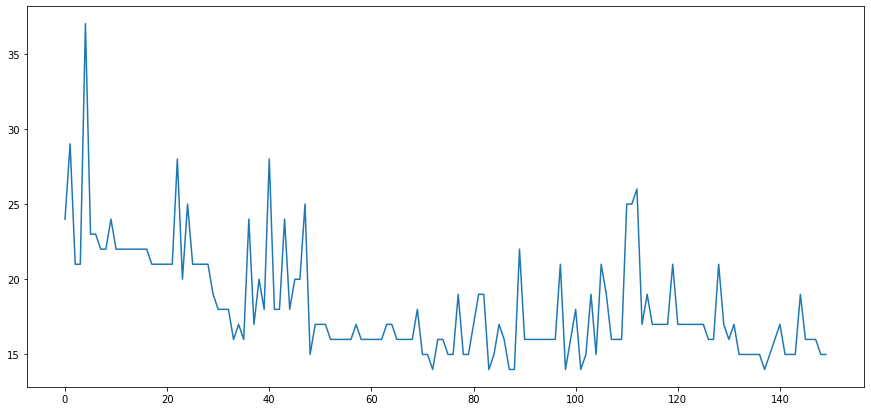

In [41]:
plt.figure(figsize=(15,7))
plt.plot((new_ch))

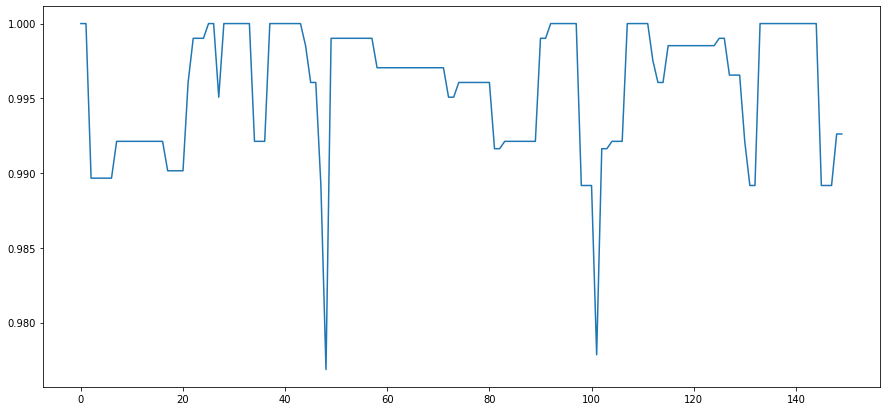

In [42]:
plt.figure(figsize=(15,7))
plt.plot((accuracy))